In [1]:
import gc

import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from func_data_generation import *
from func_polygon import *
from torch import nn
from torchsummary import summary
from utils import *
from warp_units import *

dtype = torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using cuda device


In [2]:
class WarpModel(torch.nn.Sequential):
    def __init__(self):
        super(WarpModel, self).__init__()
        self.add_module(
            "axial_dim0", AxialWarpUnit(dim=0, res=50, grad=20, lims=[0, 1.0])
        )
        self.add_module(
            "axial_dim1", AxialWarpUnit(dim=1, res=50, grad=20, lims=[-1.0, 0])
        )
        self.add_module("rbf_seq1", rbfunit_sequential(res=1, ylim=[-1, 0]))
        self.add_module("rbf_seq2", rbfunit_sequential(res=2, ylim=[-1, 0]))
        self.add_module("mobius", MobiusWarpUnit())


class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, warp_model):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        #             self.covar_module = gpytorch.kernels.GridInterpolationKernel(
        #                 gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
        #                 num_dims=2, grid_size=100
        #             )
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.space_transform = warp_model

    def forward(self, x):
        # We're first putting our data through a deep net (feature extractor)
        # We're also scaling the features so that they're nice values
        projected_x = self.space_transform(x)
        projected_x = projected_x - projected_x.min(0)[0]
        projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
random_seed = 100

np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

warp_model = WarpModel()

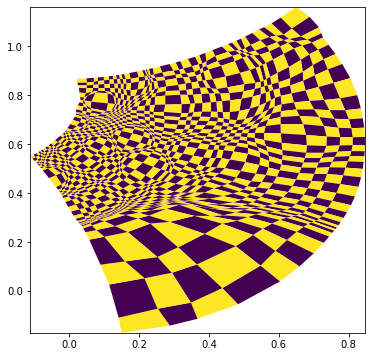

In [4]:
chessboard_from_model(warp_model)

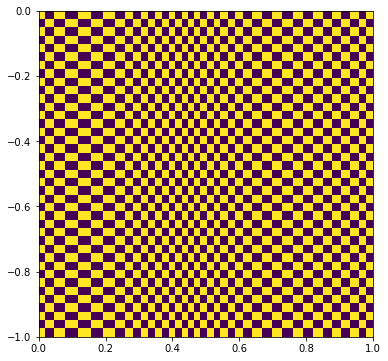

In [5]:
chessboard_from_model(warp_model.axial_dim0)

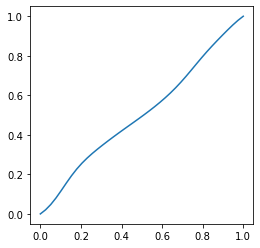

In [6]:
oned_map(warp_model.axial_dim0, dim=0)

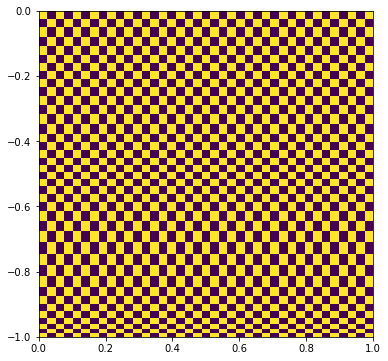

In [7]:
chessboard_from_model(warp_model.axial_dim1)

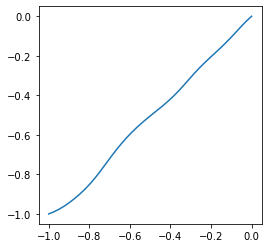

In [8]:
oned_map(warp_model.axial_dim1, dim=1)

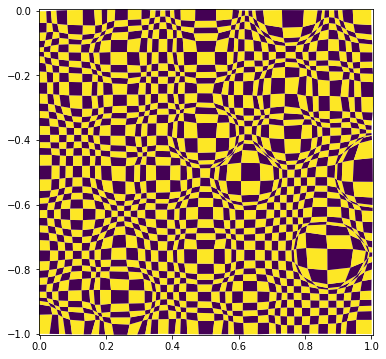

In [9]:
chessboard_from_model(warp_model.rbf_seq2)

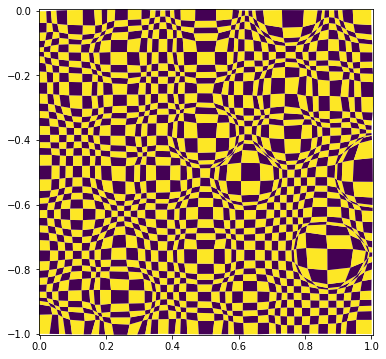

In [10]:
chessboard_from_model(warp_model.rbf_seq2)

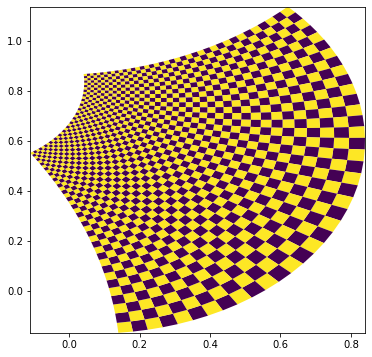

In [11]:
chessboard_from_model(warp_model.mobius)

## Data Generation

1000 * 1000 的场地上，生成1000 * 1000个点的数据

In [4]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
gp_model = GPRegressionModel(
    train_x=None, train_y=None, likelihood=likelihood, warp_model=warp_model
).to(device)
gp_model.covar_module.base_kernel.lengthscale = torch.tensor(
    [
        [
            0.1,
        ]
    ]
).to(device)
gp_model.covar_module.outputscale = torch.tensor(16.0).to(device)

In [ ]:
# for name, param in gp_model.named_parameters():
#     print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")
#     print(f"Layer:{name} | Size:{param.size()} |  \n")

In [ ]:
# # change parameter value
# gp_state_dict = gp_model.state_dict()
# gp_state_dict['covar_module.base_kernel.raw_lengthscale'] = torch.tensor([[0.4,]]).to(device)
# gp_state_dict['covar_module.raw_outputscale'] = torch.tensor(64.0).to(device)
# gp_model.load_state_dict(gp_state_dict)

In [ ]:
seed = 0
name = "test"
grid_res = 180
tran_power = 30
choose_num = 500
sigma_noise = 0.2

# generate trans_location
torch.manual_seed(seed)
tran_x = torch.rand(()) * 1000
tran_y = -torch.rand(()) * 1000
tran_loc = torch.stack((tran_x, tran_y), dim=-1)


coords, rss = get_field_data(grid_res, tran_power, tran_loc, device)
# coords = coords.to(device)

likelihood.eval()
gp_model.eval()
observed_pred = likelihood(gp_model(coords / 1000))  # GP model space is from 0 to 1
shadow = observed_pred.sample()

noise = torch.normal(0, sigma_noise, size=rss.shape).to(device)
true_rss = rss + shadow + noise

train_X, train_y, idx = random_choose(coords, true_rss, num=choose_num)

torch.save(train_X, DATA_PATH + "/" + name + "_train_X")
torch.save(train_y, DATA_PATH + "/" + name + "_train_y")
torch.save(coords, DATA_PATH + "/" + name + "_coords")
torch.save(true_rss, DATA_PATH + "/" + name + "_true_rss")

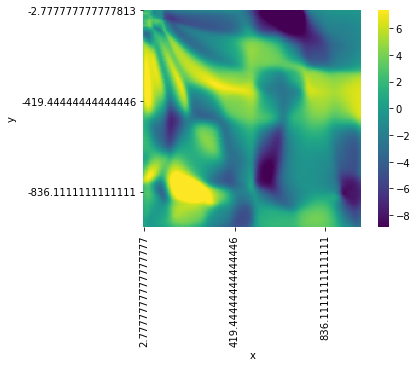

In [9]:
shadow = observed_pred.sample()
plot_heatmap(coords, shadow)
# shadow = shadow.reshape(200, 200).numpy()

In [22]:
shadow.shape

torch.Size([10000])

In [27]:
y = rss + shadow

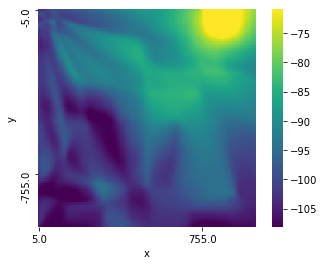

In [26]:
plot_heatmap(coords, y)

# choose 100 points evenly distributed in the area 1000 * 1000

In [27]:
train_X, train_y, idx = random_choose(coords, y, num=500)

In [28]:
idx.shape

torch.Size([500])

Saving figure system_model


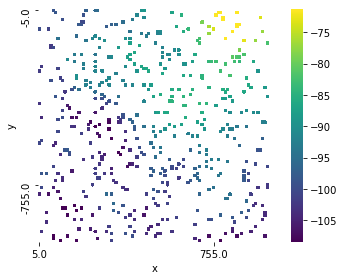

In [29]:
plot_heatmap(coords, y, mask_idx=idx)
save_fig("system_model")

In [30]:
torch.save(train_X / 1000, DATA_PATH + "/train_X")
torch.save(train_y, DATA_PATH + "/train_y")

In [55]:
def data_generation(
    gp_model,
    likelihood,
    name,
    grid_res=100,
    tran_power=30,
    seed=0,
    choose_num=500,
    sigma_noise=0.2,
):
    """
    Generate data from gp_model.
    Draw two figure: true_rss , train_y
    Store result in data floder with name_train_X, name_train_y, name_coords, name_true_rss.

    Parameter:
    ----------
    gp_model: GP model in CUDA.
    likehood: Likelihood model in CUDA.
    name: string, File name prefix for data storage.
    grid_res: int, Grid resolution for field data.
    tran_power: float, Transmmited power of signal source.
    seed: int, Random seed for generating signal source location.
    choose_num: int, Traning datasets size.

    Returns:
    --------
    train_X: torch.Tensor,
    train_y:
    idx:
    coords:
    true_rss:
    """
    torch.manual_seed(seed)
    tran_x = torch.rand(()) * 1000
    tran_y = -torch.rand(()) * 1000
    tran_loc = torch.stack((tran_x, tran_y), dim=-1)
    device = next(gp_model.parameters()).device
    coords, rss = get_field_data(grid_res, tran_power, tran_loc, device)
    noise = torch.normal(0, sigma_noise, size=rss.shape).to(device)
    coords = coords.to(device)

    likelihood.eval()
    gp_model.eval()
    observed_pred = likelihood(gp_model(coords / 1000))  # GP model space is from 0 to 1
    shadow = observed_pred.sample()
    true_rss = rss + shadow + noise

    train_X, train_y, idx = random_choose(coords, true_rss, num=choose_num)

    torch.save(train_X, DATA_PATH + "/" + name + "_train_X")
    torch.save(train_y, DATA_PATH + "/" + name + "_train_y")
    torch.save(coords, DATA_PATH + "/" + name + "_coords")
    torch.save(true_rss, DATA_PATH + "/" + name + "_true_rss")
    return train_X, train_y, idx, coords, true_rss, noise

In [63]:
train_X, train_y, idx, coords, true_rss, noise = data_generation(
    gp_model, likelihood, "test", grid_res=200, seed=10
)

RuntimeError: CUDA out of memory. Tried to allocate 11.92 GiB (GPU 0; 23.65 GiB total capacity; 13.03 GiB already allocated; 275.88 MiB free; 13.75 GiB reserved in total by PyTorch)

In [61]:
noise.shape

torch.Size([10000])

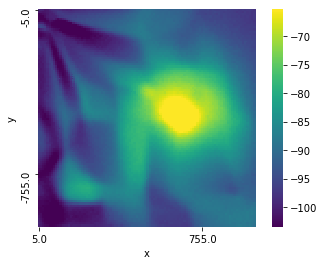

In [62]:
plot_heatmap(coords, true_rss)

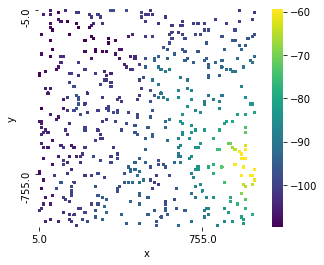

In [43]:
plot_heatmap(coords, true_rss, mask_idx=idx)